# Milestone P4 - Creative Extension

*Jimmy Paul Martin Wilde, Balz Jakob Gabriel Marty, Romain Alexandre Gros* - Group BJR

This notebook documents the creative extension to the paper [Signed networks in social media](https://doi.org/10.1145/1753326.1753532) by J. Leskovec, D. Huttenlocher, and J. Kleinberg.

### Table of contents

* [Loading data from file](#loadingData)
* [Replications](#replications)
    * [Basic network properties](#basicNetworkProperties)
        * [Nodes](#nodes)
        * [Edges](#edges)
        * [Fraction of positive and negative edges](#fractions)
        * [Triads](#triads)
    * [Triad statistics](#triadStatistics)
        * [|$T_i$|](#T_i)
        * [$p(T_i)$](#p(T_i))
        * [$p_0(T_i)$](#p_0(T_i))
        * [$s(T_i)$](#s(T_i))
* [Analyze properties of the networks](#properties)
* [Preference profile of the user](#SVD-PCA)
    * [Matrix generation](#matrixgeneration)
    * [SVD](#svd)
* [Logistic regression](#logreg)

**Note:** The the raw data have not been uploaded to github. The first three datasets have been provided by the teaching team of the ADA class. The Reddit data can be downloaded [here](https://snap.stanford.edu/data/soc-RedditHyperlinks.html). The file structure should be the following for the code to work as it is:

```
ada-2020-project-milestone-p3-p3_bjr
│   creative_extension.ipynb
│
└───images
│   │   table1.jpg
│   │   table3.jpg
│
└───rawData
    │   soc-sign-epinions.txt
    │   soc-sign-Slashdot090221.txt
    │   wikiElec.ElecBs3.txt
    │   soc-redditHyperlinks-title.tsv
    │   soc-redditHyperlinks-body.tsv
    
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image
import linecache # to read a single line in textfile

import os
import os.path

# Print progress bars (cosmetics)
import time
import progressbar

# Set path to folder used for storing results of lengthy computations...
PATH_OUTPUT_FOLDER = "./results/"
# ...and creating the folder if it doesn't exist already.
try:
    os.makedirs(PATH_OUTPUT_FOLDER)    
    print("Directory " , PATH_OUTPUT_FOLDER ,  " created ")
except FileExistsError:
    print("Directory " , PATH_OUTPUT_FOLDER ,  " already exists")

Directory  ./results/  already exists


## Loading data from file <a class="anchor" id="loadingData"></a>

The variable PATH_TO_DATA to must be set to the relative path to the folder which contains the three raw data files `soc-sign-epinions.txt`, `soc-sign-Slashdot090221.txt`, and `wikiElec.ElecBs3.txt`. 

In [2]:
PATH_TO_DATA = "./rawData/"
        
# set pandas print options
pd.set_option('max_rows', 5) # don't show more than 5 rows
pd.options.display.float_format = '{:,.3f}'.format # print floats with one three places

The datasets from the *Epinions* product review Web site and the blog *Slashdot* are already stored in the right format for the purposes of this replication exercise.

In [3]:
filename_epinions = "soc-sign-epinions.txt"
data_epinions = pd.read_table(PATH_TO_DATA+filename_epinions, names=["FromNodeId", "ToNodeId", "Sign"], comment='#')
data_epinions

,FromNodeId,ToNodeId,Sign
0,0,1,-1
1,1,128552,-1
...,...,...,...
841370,131825,131826,1
841371,131827,7714,1


In [4]:
filename_slashdot = "soc-sign-Slashdot090221.txt"
data_slashdot = pd.read_table(PATH_TO_DATA+filename_slashdot, names=["FromNodeId", "ToNodeId", "Sign"], comment='#')
data_slashdot

,FromNodeId,ToNodeId,Sign
0,0,1,1
1,0,2,1
...,...,...,...
549200,82143,81974,1
549201,82143,82136,1


The dataset from from the Wikipedia voting network on the other hand needs to be parsed manually since it is not structured like a classical `.csv` file.

In [5]:
filename_wikipedia = "wikiElec.ElecBs3.txt"

# Initialize list to store the edges of the network
data_wikipedia = []

with open(PATH_TO_DATA+filename_wikipedia, "r", encoding="ANSI") as wiki_file:
    
    # Initializing variable to keep track which user's status the vote is about
    ToNodeId = None
    
    # Read file line by line and extract the two nodes and the sign for each link
    for line in wiki_file:
        if line[0]=='U':
            ToNodeId = int(line.split('\t')[1])
        if line[0]=='V':
            _,Sign,FromNodeId,_,_=line.split('\t')
            data_wikipedia.append([int(FromNodeId), ToNodeId, int(Sign)])

# Convert to DataFrame with the same structure as the other datasets
data_wikipedia = pd.DataFrame(data_wikipedia, columns=["FromNodeId", "ToNodeId", "Sign"])
# Remove neutral votes and keep only signed connections
data_wikipedia = data_wikipedia[data_wikipedia['Sign']!=0]
data_wikipedia

LookupError: unknown encoding: ANSI

In [6]:
# LookupError                               Traceback (most recent call last)
# <ipython-input-5-f4d81017a0dc> in <module>
#       4 data_wikipedia = []
#       5 
# ----> 6 with open(PATH_TO_DATA+filename_wikipedia, "r", encoding="ANSI") as wiki_file:
#       7 
#       8     # Initializing variable to keep track which user's status the vote is about
# 
# LookupError: unknown encoding: ANSI

# j'ai cette erreur quand je run la cellule, je pense que c'est à cause de mon OS

In [7]:
# This file was generated after parsing the data manually
filename_wikipedia = "soc-sign-wikipedia.txt"
data_wikipedia = pd.read_table(PATH_TO_DATA+filename_wikipedia)
data_wikipedia

,FromNodeId,ToNodeId,Sign
0,3,28,1
1,3,30,1
...,...,...,...
103745,8273,4940,1
103746,8274,8275,-1


The Reddit dataset comes in two parts. Links from one subreddit to another can originate either in the title or the body of a post. For simplicity, we treat these two cases as equivalent. Any additional information available in the dataset, which goes beyond signed edges between nodes, is not considered.

In [8]:
filenames_reddit = ["soc-redditHyperlinks-title.tsv","soc-redditHyperlinks-body.tsv"]

In [9]:
data_reddit = pd.concat(   [pd.read_table(PATH_TO_DATA+file, header=0,usecols=[0,1,4],
                                          names=["FromNodeId","ToNodeId","Sign"]) 
                                                        for file in filenames_reddit], ignore_index=True)                         
# convert usernames to unique identifier
IDs, unique_usernames = pd.factorize(data_reddit[["FromNodeId","ToNodeId"]].values.flatten())
data_reddit[["FromNodeId","ToNodeId"]] = IDs.reshape(-1,2)
data_reddit

,FromNodeId,ToNodeId,Sign
0,0,1,1
1,2,3,1
...,...,...,...
858486,63969,43,1
858487,265,573,1


## Replications <a class="anchor" id="replications"></a>

In this first part, we repeat the analysis that the task of the individual asignments on all four datasets. We do so just to see if the results are also valid on the Reddit data. Please note that we do not always make the same design choices as Leskovec *et al.* since we are not trying to replicate tables from the original paper anymore. We rather treat the the data as a directed graph without multi-edges or self-connections. **This part was adapted from Balz Marty's solution to the individual assignments.**

In [10]:
# The datasets are stored in a dictionary
datasets = {'Epinions' : data_epinions, 'Slashdot' : data_slashdot, 
            'Wikipedia' : data_wikipedia, 'Reddit' : data_reddit}
            
for key in datasets.keys():
    # remove non-unique edges - keep only the last of a set of multi-edges in the order they appear in the edge list.
    lengths = [len(datasets[key])]
    datasets[key] = datasets[key].drop_duplicates(subset=['FromNodeId', 'ToNodeId'], keep='last')
    lengths.append(len(datasets[key]))
    # remove edges of nodes with themselves
    datasets[key] = datasets[key][datasets[key]['FromNodeId']!=datasets[key]['ToNodeId']]
    lengths.append(len(datasets[key]))
    nb_non_unique,nb_self = np.diff(lengths)
    print(key," :\n","\t#multi-edges removed : {}\n\t#self_conections removed : {}\n".format(nb_non_unique,nb_self))

Epinions  :
 	#multi-edges removed : 0
	#self_conections removed : -573

Slashdot  :
 	#multi-edges removed : 0
	#self_conections removed : 0

Wikipedia  :
 	#multi-edges removed : 0
	#self_conections removed : -58

Reddit  :
 	#multi-edges removed : -518845
	#self_conections removed : 0



### Basic network properties <a class="anchor" id="basicNetworkProperties"></a>

First, we calculate the basic dataset statistics, which were shown in [Table 1](#table1).

<a id='table1'></a>

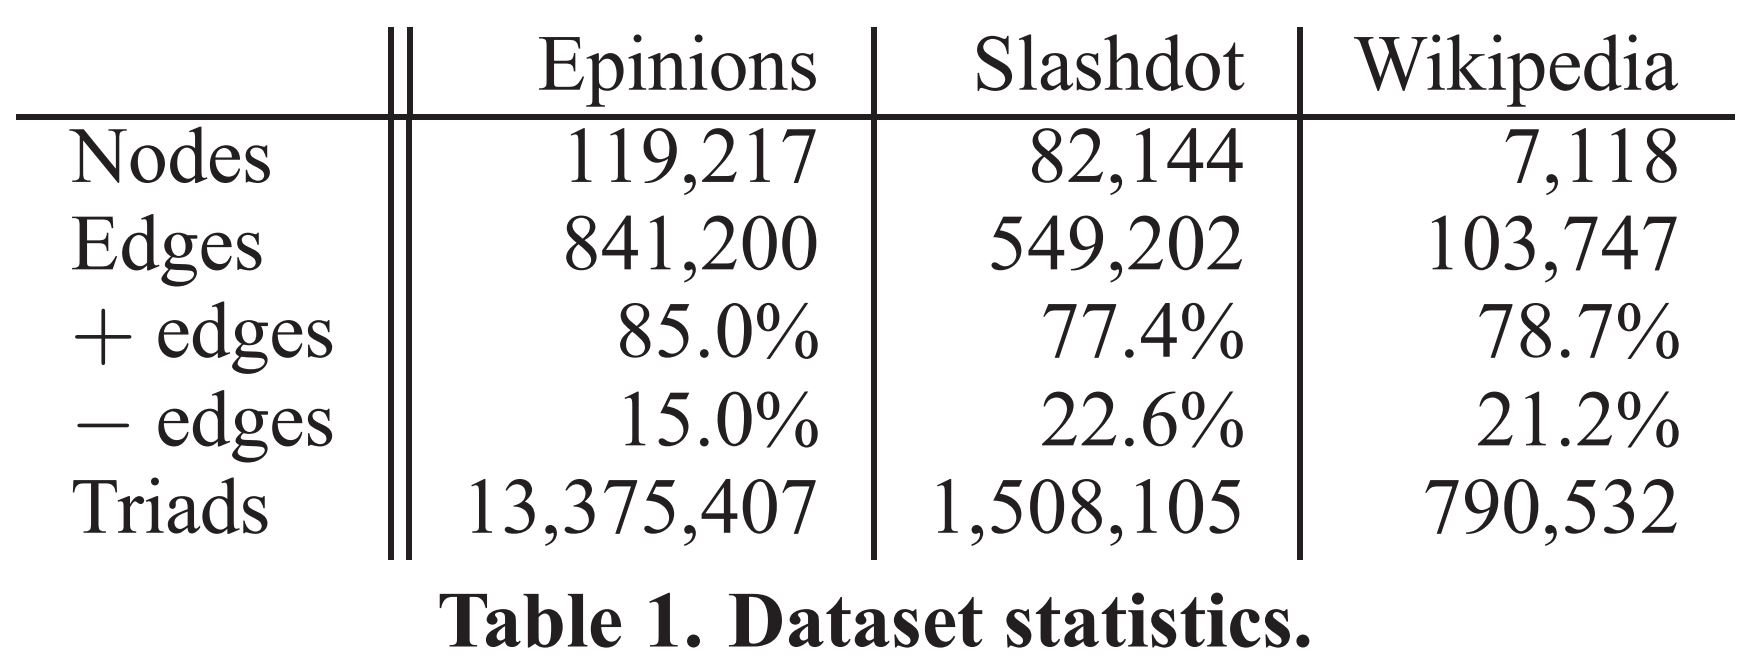

In [11]:
Image('./images/table1.jpg', width=400,height=300) 

In [12]:
dataset_statistics = pd.DataFrame(index=datasets.keys())

#### Nodes <a class="anchor" id="nodes"></a>

The datasets take the form of lists of edges. Given our assumptions from above, the number of nodes in each network is then naturally given by the number of unique nodes connected by these links.

In [13]:
def calculate_nb_nodes(dataset):
    # Calculate the number of unique edges 
    return len(np.unique(dataset.to_numpy()[:,:2]))

dataset_statistics['Nodes'] = [calculate_nb_nodes(dataset) for dataset in datasets.values()]
dataset_statistics

,Nodes
Epinions,131580
Slashdot,82140
Wikipedia,7115
Reddit,67180


#### Edges <a class="anchor" id="edges"></a>

The number of edges corresponds just the number of rows in each dataset. Note that we already removed multi-edges and self-connections.

In [14]:
def calculate_nb_edges(dataset):
    # Calculate the number of unique links. The weight of the connection is not considered.
    return len(np.unique(dataset.to_numpy()[:,:2],axis=0))

dataset_statistics['Edges'] = [calculate_nb_edges(dataset) for dataset in datasets.values()]
dataset_statistics

,Nodes,Edges
Epinions,131580,840799
Slashdot,82140,549202
Wikipedia,7115,103689
Reddit,67180,339643


#### Fraction of positive and negative edges <a class="anchor" id="fractions"></a>

Now, the fraction of positive and negative *Signs* of the edges is calculated.

In [15]:
# count positive and negative edges
dataset_statistics['+ edges'] = [np.count_nonzero(dataset['Sign'] == +1) for dataset in datasets.values()]
dataset_statistics['- edges'] = [np.count_nonzero(dataset['Sign'] == -1) for dataset in datasets.values()]
# divide total number of edges
dataset_statistics[['+ edges','- edges']] = \
                        dataset_statistics[['+ edges','- edges']].div(dataset_statistics.Edges, axis='index')
dataset_statistics

,Nodes,Edges,+ edges,- edges
Epinions,131580,840799,0.853,0.147
Slashdot,82140,549202,0.774,0.226
Wikipedia,7115,103689,0.788,0.212
Reddit,67180,339643,0.925,0.075


#### Triads <a class="anchor" id="triads"></a>

Counting the number of triads is somewhat more challenging. The function bellow does so by first calculating the list of neighbors for each node. Then it iterates through all nodes. For each of them it looks up its neighbors and the neighbors of each neighbor. Then it counts the number of nodes that are both neighbor and neighbor's neighbor to the original node - another definition of a triad. This yields *six* times the numbers of triads. For each node, the number of triads it participates in is counted *twice* since being a neighbor is a bidirectional connection. And the same triad is counted once for all *three* nodes that participate in it.

In [16]:
def get_nb_triads(dataset):
    """This function calculates the number of triads in a dataset"""
    
    # extracting edges from dataset
    edges=dataset.to_numpy()[:,:2]
    # remove non-unique edges - see discussion on edge count
    edges=np.unique(edges,axis=0)
    # remove edges of nodes with themselves
    edges=edges[edges[:,0]!=edges[:,1]]
    
    # listing neighbors for each node
    neighbors = [[] for i in range(np.max(edges)+1)]
    for [u,v] in edges:
        neighbors[u]+=[v]
        neighbors[v]+=[u]
    
    # iterating through nodes and counting nodes that are both neighbor and neighbor's neighbor to original node
    triads = 0    
    nodes = np.unique(edges.flatten())
    for node in nodes:
        neighbors_node = neighbors[node]
        neighbors_neighbours = np.concatenate([neighbors[neighbor] for neighbor in neighbors_node])
        triads+=sum([np.count_nonzero(neighbors_neighbours==neighbor) for neighbor in neighbors_node])
    # correcting for overcounting
    assert triads%6 == 0
    return triads//6

Although this is an efficient way of calculating the number of triads, it still takes a few minutes to do so. Ideally, the result is therefore stored to file. If such an output file exists, the result is read from there. Otherwise, the triads are counted and the result gets stored.

In [17]:
PATH_TRIAD_COUNT = PATH_OUTPUT_FOLDER + "triad_count.npy"

In [18]:
# If the output file exists, the result is read from there.
if os.path.isfile(PATH_TRIAD_COUNT): 
    dataset_statistics['Triads'] = np.load(PATH_TRIAD_COUNT)
else:
    dataset_statistics['Triads'] = [int(get_nb_triads(dataset)) for dataset in datasets.values()]
    np.save(PATH_TRIAD_COUNT,dataset_statistics['Triads'].to_numpy())
dataset_statistics

,Nodes,Edges,+ edges,- edges,Triads
Epinions,131580,840799,0.853,0.147,13317672
Slashdot,82140,549202,0.774,0.226,1508105
Wikipedia,7115,103689,0.788,0.212,790532
Reddit,67180,339643,0.925,0.075,4077337


### Triad statistics <a class="anchor" id="triadStatistics"></a>

In the following, the analysis to generate [Table 3](#table3) as in milestone P4 is performed on all datasets.

<a id='table1'></a>

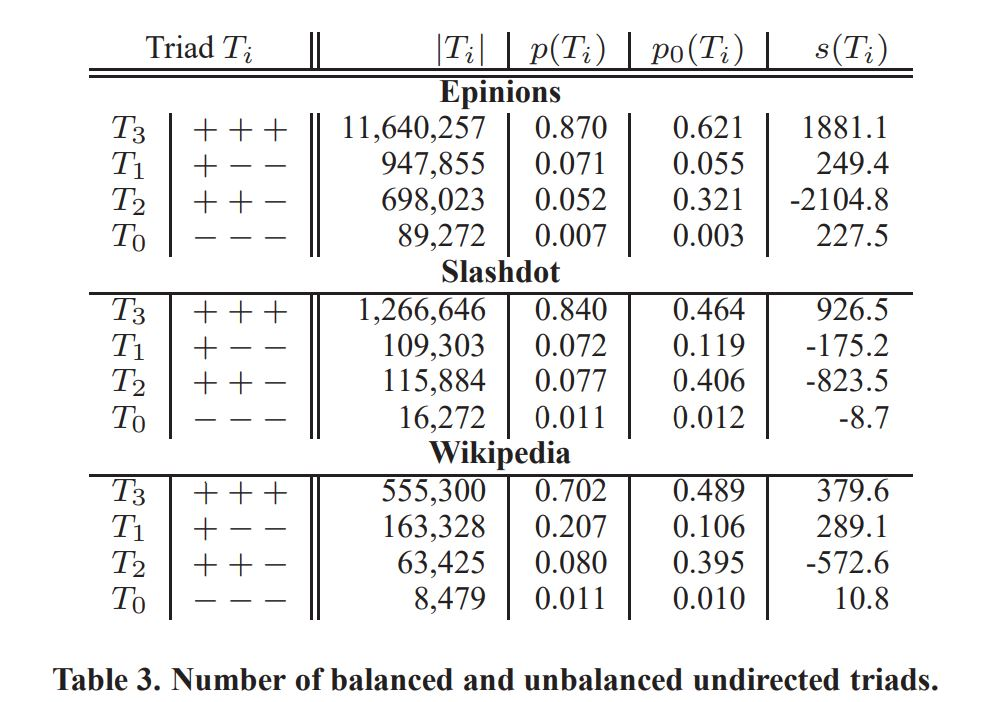

In [19]:
Image('./images/table3.jpg', width=400,height=300)

#### |$T_i$| <a class="anchor" id="T_i"></a>

For replicating *Table 1*, I already wrote a function, which counts the number of triads in a given network. Here, I need to keep track of the signs of the edges that make up those triads as well. The function bellow is an adapted version of the previous triad count function that does so.

First, it again generates the list of neighbors for each node. In addition, a list of the signs of the corresponding edges is created (-1s are stored as 0s to facilitate keeping track of the number of positive edges in a triad). The function then iterates through all nodes. For each of them it looks up its neighbors and the neighbors of each neighbor. It also counts the number of positive edges out of two edges for each triplet *node-neighbor-neighbor's neighbor*. Finally, for all nodes that are both neighbor and neighbor's neighbor to the original node, it computes the number of positive edges in this corresponding triad. This yields again *six* times the count for each triad type. For each node, the number of triads it participates in is counted *twice* since being a neighbor is a bidirectional connection. And the same triad is counted once for all *three* nodes that participate in it.

In [20]:
from collections import Counter

def get_nb_triads_by_type(dataset):
    """This function calculates the number of triads in a dataset"""
    
    # remove non-unique edges - see discussion on edge count and convert to numpy
    edges = dataset.drop_duplicates(subset=['FromNodeId', 'ToNodeId'], keep='last').to_numpy()
    # remove edges of nodes with themselves
    edges=edges[edges[:,0]!=edges[:,1]]

    # listing neighbors for each node and the signs of the corresonding connections
    neighbors = [[] for i in range(np.max(edges)+1)]
    signs = [[] for i in range(np.max(edges)+1)]

    for [u,v,s] in edges:
        neighbors[u]+=[v]
        neighbors[v]+=[u]
        signs[u]+=[max(0,s)]
        signs[v]+=[max(0,s)]
    
    
    # iterating through nodes and for each node that is both neighbor and neighbor's neighbor to original node 
    # counting incrementing the count of the corresponding triad type
    triad_counter = Counter() 
    nodes = np.unique(edges[:,:2].flatten())
    
    with progressbar.ProgressBar(max_value=nodes.shape[0]) as bar:
        for node in nodes:
            neighbors_node, signs_node = neighbors[node],signs[node]
            neighbors_neighbours = np.concatenate([neighbors[neighbor] for neighbor in neighbors_node])
            neighbors_signs = np.concatenate([np.array(signs[neighbor])+sign \
                                              for (neighbor,sign) in zip(neighbors_node,signs_node)])
            for (neighbor,sign) in zip(neighbors_node,signs_node):
                triad_counter+=Counter(neighbors_signs[neighbors_neighbours==neighbor]+sign)
        # converting to dataframe and correcting for overcounting
        triad_counter = pd.DataFrame.from_dict(triad_counter, orient='index',columns=['|T_i|'])//6
        triad_counter.index.name = '#+edges'
    return triad_counter

In [21]:
PATH_TRIAD_COUNT_BY_TYPE = PATH_OUTPUT_FOLDER + "triad_count_by_type_"

In [22]:
# If the output file exists, the result is read from there.
triad_statistics = dict()
for key, dataset in datasets.items():
    if os.path.isfile(PATH_TRIAD_COUNT_BY_TYPE+key+".pkl"):
        triad_statistics[key] = pd.read_pickle(PATH_TRIAD_COUNT_BY_TYPE+key+".pkl")
    else:
        triad_statistics[key] = get_nb_triads_by_type(dataset)
        triad_statistics[key].to_pickle(PATH_TRIAD_COUNT_BY_TYPE+key+".pkl")
    # print triad count by type
    print(key+" :\n", triad_statistics[key], end="\n\n")

Epinions :
             |T_i|
#+edges          
3        11616708
1          688557
2          924739
0           87668

Slashdot :
            |T_i|
#+edges         
3        1266646
1         115884
2         109303
0          16272

Wikipedia :
           |T_i|
#+edges        
3        555300
1         63425
2        163328
0          8479

Reddit :
            |T_i|
#+edges         
3        2841801
2        1023576
1         197192
0          14768



I introduce a DataFrame that stores features of datasets such as the number of triads per dataset. A quick sanity check shows that I get the same counts as above.

In [23]:
datasets_features = pd.DataFrame([sum(table['|T_i|']) for table in triad_statistics.values()],index=datasets.keys(),
                               columns=['#Triads'])
# Check that I get the same total number of triads as before
pd.testing.assert_series_equal(dataset_statistics['Triads'],datasets_features['#Triads'],
                               check_dtype=False,check_names=False)
datasets_features

,#Triads
Epinions,13317672
Slashdot,1508105
Wikipedia,790532
Reddit,4077337


#### $p(T_i)$ <a class="anchor" id="p(T_i)"></a>

The next column contains the fraction of triads of type $T_i$. It is a simple division of the number of triads for each type by the total number of triads in a given network.

In [24]:
for (key, table),nb_triads in zip(triad_statistics.items(),datasets_features['#Triads']):
    table['p(T_i)'] = table['|T_i|']/nb_triads
    print(key+" :\n",table,end="\n\n")

Epinions :
             |T_i|  p(T_i)
#+edges                  
3        11616708   0.872
1          688557   0.052
2          924739   0.069
0           87668   0.007

Slashdot :
            |T_i|  p(T_i)
#+edges                 
3        1266646   0.840
1         115884   0.077
2         109303   0.072
0          16272   0.011

Wikipedia :
           |T_i|  p(T_i)
#+edges                
3        555300   0.702
1         63425   0.080
2        163328   0.207
0          8479   0.011

Reddit :
            |T_i|  p(T_i)
#+edges                 
3        2841801   0.697
2        1023576   0.251
1         197192   0.048
0          14768   0.004



#### $p_0(T_i)$ <a class="anchor" id="p_0(T_i)"></a>

For the calculation of the *a priori probability of $T_i$*, I need to know the fraction of of positive edges in the network $p$. This was already calculated in milestone P2 and can be recycled here.

In [25]:
def calculate_frac_pos_edges(dataset):
    # Calculate the number of unique links. The weight of the connection is not considered.
    unique_edges = dataset.drop_duplicates(subset=['FromNodeId', 'ToNodeId'],keep='last')
    return np.count_nonzero(unique_edges['Sign'] == +1)/len(unique_edges)

datasets_features['p'] = [calculate_frac_pos_edges(dataset) for dataset in datasets.values()]
datasets_features

,#Triads,p
Epinions,13317672,0.853
Slashdot,1508105,0.774
Wikipedia,790532,0.788
Reddit,4077337,0.925


The *a priori* probability of $T_i$ based on sign distribution, $p_0(T_i)$, is given by a binomial distribution:
$$p_0(T_i)   = {n \choose k} p^k (1-p)^{ n-k}$$
, where $n=3$ is the number of edges per triad, $k$ is the number of positive edges in the given triad type, and $p$ is the fraction of positive edges in the entire network, which is asumed to be the *a priori* probability that an edge is positive.

In [26]:
from scipy.stats import binom
for (key, table),p in zip(triad_statistics.items(),datasets_features['p']):
    table['p0(T_i)'] = binom.pmf(table.index.get_level_values('#+edges'), 3, p)
    print(key+" :\n",table,end="\n\n")

Epinions :
             |T_i|  p(T_i)  p0(T_i)
#+edges                           
3        11616708   0.872    0.620
1          688557   0.052    0.055
2          924739   0.069    0.321
0           87668   0.007    0.003

Slashdot :
            |T_i|  p(T_i)  p0(T_i)
#+edges                          
3        1266646   0.840    0.464
1         115884   0.077    0.119
2         109303   0.072    0.406
0          16272   0.011    0.012

Wikipedia :
           |T_i|  p(T_i)  p0(T_i)
#+edges                         
3        555300   0.702    0.489
1         63425   0.080    0.106
2        163328   0.207    0.395
0          8479   0.011    0.010

Reddit :
            |T_i|  p(T_i)  p0(T_i)
#+edges                          
3        2841801   0.697    0.791
2        1023576   0.251    0.193
1         197192   0.048    0.016
0          14768   0.004    0.000



#### $s(T_i)$ <a class="anchor" id="s(T_i)"></a>

The surprise, $s(T_i)$, of finding a number, $|T_i|$, of a given triad type, $T_i$, is given by the following formula:
$$s(T_i)=\frac{|T_i|-E[|T_i|]}{\sqrt{\Delta p_0(T_i)(1-p_0(T_i))}}$$

In [27]:
for (key, table),nb_triads in zip(triad_statistics.items(),datasets_features['#Triads']):
    table['s(T_i)']=(table['|T_i|']-table['p0(T_i)']*nb_triads)\
                    /np.sqrt(nb_triads*table['p0(T_i)']*(1-table['p0(T_i)']))
    print(key+" :\n",table,end="\n\n")

Epinions :
             |T_i|  p(T_i)  p0(T_i)     s(T_i)
#+edges                                      
3        11616708   0.872    0.620  1,893.701
1          688557   0.052    0.055    -58.317
2          924739   0.069    0.321 -1,966.401
0           87668   0.007    0.003    220.352

Slashdot :
            |T_i|  p(T_i)  p0(T_i)   s(T_i)
#+edges                                   
3        1266646   0.840    0.464  926.538
1         115884   0.077    0.119 -158.663
2         109303   0.072    0.406 -834.445
0          16272   0.011    0.012   -8.695

Wikipedia :
           |T_i|  p(T_i)  p0(T_i)   s(T_i)
#+edges                                  
3        555300   0.702    0.489  379.153
1         63425   0.080    0.106  -75.108
2        163328   0.207    0.395 -342.545
0          8479   0.011    0.010   10.936

Reddit :
            |T_i|  p(T_i)  p0(T_i)   s(T_i)
#+edges                                   
3        2841801   0.697    0.791 -469.323
2        1023576   0.251    0.193  

In [28]:
from tabulate import tabulate

def pretty_print(table):
    ''' This function generates a pretty print for our results '''
    
    for key in table:
        if key == 'Reddit':
            new_index = [3, 1, 2, 0]
            table[key] = table[key].reindex(new_index)
        table[key] = table[key].rename(index={3: 'T₃', 1: 'T₁', 2: 'T₂', 0: 'T₀'})
        table[key] = table[key].rename(columns = {'#+edges ':'', '|T_i|':'|Tᵢ|', 'p(T_i)': 'p(Tᵢ)', 'p0(T_i)': 'p₀(Tᵢ)',
                                                  's(T_i)' : 's(Tᵢ)'})

    
    df_names = ['Epinions', 'Slashdot', 'Wikipedia', 'Reddit']

    print('\033[1m'+'\t\tPaper table 3 - reproduced.\n')
    print ('\033[0m')

    for key in table:
        print('\t\t\t\033[1m' + key + '\033[0m')
        print(tabulate(table[key], headers = 'keys', tablefmt="fancy_grid", numalign="right", 
                       floatfmt=(None,'.0f','.3f','.3f','.1f')))
        print('\n')

In [29]:
pretty_print(triad_statistics)

		Paper table 3 - reproduced.


			Epinions
╒═══════════╤══════════╤═════════╤══════════╤═════════╕
│ #+edges   │     |Tᵢ| │   p(Tᵢ) │   p₀(Tᵢ) │   s(Tᵢ) │
╞═══════════╪══════════╪═════════╪══════════╪═════════╡
│ T₃        │ 11616708 │   0.872 │    0.620 │  1893.7 │
├───────────┼──────────┼─────────┼──────────┼─────────┤
│ T₁        │   688557 │   0.052 │    0.055 │   -58.3 │
├───────────┼──────────┼─────────┼──────────┼─────────┤
│ T₂        │   924739 │   0.069 │    0.321 │ -1966.4 │
├───────────┼──────────┼─────────┼──────────┼─────────┤
│ T₀        │    87668 │   0.007 │    0.003 │   220.4 │
╘═══════════╧══════════╧═════════╧══════════╧═════════╛


			Slashdot
╒═══════════╤═════════╤═════════╤══════════╤═════════╕
│ #+edges   │    |Tᵢ| │   p(Tᵢ) │   p₀(Tᵢ) │   s(Tᵢ) │
╞═══════════╪═════════╪═════════╪══════════╪═════════╡
│ T₃        │ 1266646 │   0.840 │    0.464 │   926.5 │
├───────────┼─────────┼─────────┼──────────┼─────────┤
│ T₁        │  115884 │   0.077 │    0.119 │  -158.

## Analyze properties of the networks <a class="anchor" id="properties"></a>

In [30]:
import networkx as nx
from networkx.convert_matrix import from_pandas_edgelist
from networkx.algorithms.approximation import clustering_coefficient
from networkx import average_shortest_path_length
import random
import pickle

def bootstrap_CI_mean(data, nbr_draws = 1000):
    """ bootstrap_CI_mean returns a 95% CI of the mean of 'data'
    data
    nbr_draws: number of draws that should be performed to compute the bootstraped CI
    """ 
    sample_size = len(data)
    samples = data.sample(n = sample_size*nbr_draws, replace = True, random_state=0).values\
              .reshape((sample_size,nbr_draws))
    means = np.mean(samples,axis=0)
    return np.asarray([np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)])

# -------------------

def compute_properties(datasets):
    graphs = {}
    for key in datasets:
        G = nx.from_pandas_edgelist(datasets[key][['FromNodeId','ToNodeId']], source = 'FromNodeId', 
                                    target = 'ToNodeId')
        graphs[key] = G
        
    properties = {}
    for key in datasets:
        properties[key] = {}

    for key in graphs:
        clustering = nx.clustering(graphs[key])
        properties[key]['mean_clustering'] = np.array(list(clustering.values())).mean()
        properties[key]['95%CI_clustering'] = bootstrap_CI_mean(pd.Series(list(clustering.values())))
        
    ccs = []
    for key in graphs:
        ccs_ = max(nx.connected_components(graphs[key]), key = len)
        ccs.append([ccs_, len(ccs_)])
    print('The fraction of connected components for each dataset are the following:')
    print(np.array(ccs)[:,1]/dataset_statistics['Nodes']*100)
    print('\nSince three of our four graphs arent connected, we will compute the average shortest path length for the bigger connected components each time.\n')
    
    sample_nb = 200

    for idx, key in enumerate(graphs):
        print(key)
        random.seed(5)
        sample = random.sample(range(0, len(ccs[idx][0])-1),sample_nb)
        sources = list(ccs[idx][0])
        biggest_graph = graphs[key].subgraph(ccs[idx][0]).copy()

        with progressbar.ProgressBar(max_value=sample_nb) as bar:
            aspl = []
            for idx, samp in enumerate(sample):
                aspl.append(np.array(list(nx.shortest_path_length(biggest_graph, source = sources[samp]).values())))
                bar.update(idx+1)
        properties[key]['mean_aspl'] = np.mean(np.concatenate(aspl, axis=0))
        properties[key]['95%CI_aspl'] = bootstrap_CI_mean(pd.Series(np.concatenate( aspl, axis=0)), nbr_draws = 10)

    return properties

In [31]:
PATH_PROPERTIES = PATH_OUTPUT_FOLDER + "properties.pickle"

In [32]:
if os.path.isfile(PATH_PROPERTIES):
    with open(PATH_PROPERTIES, 'rb') as f:
        properties = pickle.load(f)
else:
    properties = compute_properties(datasets)

In [33]:
clustering = []
aspl = []

for key in properties:
    clustering.append([key, properties[key]['mean_clustering'], properties[key]['95%CI_clustering']])
    aspl.append([key, properties[key]['mean_aspl'], properties[key]['95%CI_aspl']])

In [34]:
def pretty_print_property(table, clustering = False):
    ''' This function generates a pretty print for our results '''
    if clustering:
        table = table.rename(columns = {1:'Clustering coefficient', 2:'95% CI'})
    else:
        table = table.rename(columns = {1:'Average shortest path length', 2:'95% CI'})


    print(tabulate(table, headers = 'keys', tablefmt="fancy_grid", numalign="right"))
    print('\n')

In [35]:
clustering = pd.DataFrame(clustering).set_index(0)
clustering.index.names = ['Dataset']
aspl = pd.DataFrame(aspl).set_index(0)
aspl.index.names = ['Dataset']

In [36]:
pretty_print_property(clustering, clustering = True)
pretty_print_property(aspl)

╒═══════════╤══════════════════════════╤═════════════════════════╕
│ Dataset   │   Clustering coefficient │ 95% CI                  │
╞═══════════╪══════════════════════════╪═════════════════════════╡
│ Epinions  │                 0.128186 │ [0.12678899 0.12961191] │
├───────────┼──────────────────────────┼─────────────────────────┤
│ Slashdot  │                0.0587871 │ [0.05737831 0.0599923 ] │
├───────────┼──────────────────────────┼─────────────────────────┤
│ Wikipedia │                 0.140898 │ [0.13658216 0.14579731] │
├───────────┼──────────────────────────┼─────────────────────────┤
│ Reddit    │                 0.216967 │ [0.21445482 0.21957991] │
╘═══════════╧══════════════════════════╧═════════════════════════╛


╒═══════════╤════════════════════════════════╤═════════════════════════╕
│ Dataset   │   Average shortest path length │ 95% CI                  │
╞═══════════╪════════════════════════════════╪═════════════════════════╡
│ Epinions  │                         4.15

TO DO: maybe have a look at Graph Laplacian

## Visualization of the "preference profiles" of users <a class="anchor" id="SVD-PCA"></a>

### Matrix generation <a class="anchor" id="matrixgeneration"></a>

In a first time, we have to build matrices from which we will be able to perform SVD. Each row corresponds to an
individual, each column corresponds to the link they receive from other individuals. The 'weight' corresponds to the sum of edges signs between the two individuals

In [37]:
# Reload the data in case they have been modified
data_epinions = pd.read_table(PATH_TO_DATA+filename_epinions, 
                              names=["FromNodeId", "ToNodeId", "Sign"], comment='#')
data_slashdot = pd.read_table(PATH_TO_DATA+filename_slashdot, 
                              names=["FromNodeId", "ToNodeId", "Sign"], comment='#')
data_wikipedia = pd.read_table(PATH_TO_DATA+filename_wikipedia)
data_reddit = pd.concat(   [pd.read_table(PATH_TO_DATA+file, header=0,usecols=[0,1,4],
                                          names=["FromNodeId","ToNodeId","Sign"]) 
                                                        for file in filenames_reddit], ignore_index=True)
IDs, unique_usernames = pd.factorize(data_reddit[["FromNodeId","ToNodeId"]].values.flatten())
data_reddit[["FromNodeId","ToNodeId"]] = IDs.reshape(-1,2)
datasets = [data_epinions, data_slashdot, data_wikipedia, data_reddit]

In [38]:
from scipy.sparse import lil_matrix, csr_matrix
from sklearn.decomposition import TruncatedSVD

# ----------

def fill_matrix_for_row(row, matrix):
    matrix[row['ToNodeId'], row['FromNodeId']] += 1
    return row

# ----------

def generate_matrix(datasets):
    matrices = []
    for idx, data in enumerate(datasets):
        dimension = max(max(data['FromNodeId'].values), max(data['ToNodeId'].values))+1
        matrix = lil_matrix((dimension, dimension))
        edges = data.to_numpy()
        for edge in edges:
            matrix[edge[0],edge[1]] += edge[2]
        matrix = csr_matrix(matrix)
        matrices.append(matrix)
    return matrices

In [39]:
matrices = generate_matrix(datasets)

# Sanity check
for i, matrix in enumerate(matrices):
    assert matrix.sum() == datasets[i]['Sign'].sum()

### SVD <a class="anchor" id="svd"></a>

Now that we have generated our (sparse) matrices, we can perform svd to allow data dimensionality reduction.

In [47]:
def compute_svd(matrices):
    k=10
    matrix_pca = []
    for idx, matrix in enumerate(matrices):
        svd = TruncatedSVD(k)
        matrix_transformed = svd.fit_transform(matrix)
        explained_variances = svd.explained_variance_ratio_
        matrix_pca.append([matrix_transformed, explained_variances])
    return matrix_pca

In [48]:
matrix_pca = compute_svd(matrices)

In [50]:
def select_n_components(var_ratio, goal_var = 0.8):
    total_variance = 0.0
    n_components = 0
    for explained_variance in var_ratio:
        total_variance += explained_variance
        n_components += 1
        if total_variance >= goal_var:
            break
    print(total_variance)
    return n_components

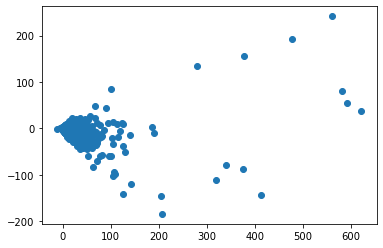

In [70]:
idx = 3
plt.scatter(matrix_pca[idx][0][:,0], matrix_pca[idx][0][:,1])

To do: try to improve svd, but will not work well imo

## Logistic regression <a class="anchor" id="logreg"></a>

To do: generate features which are expected to have more or less predictive power depending on the different theoretical considerations (e.g. the number of common neighbors, a balance and a status score based on the triads that the edge is involved in, etc.)